In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

Map:   0%|          | 0/2433 [00:00<?, ? examples/s]

Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.692500,0.699309,0.735306
2,0.600600,0.526911,0.796547
3,0.432000,0.525459,0.797781


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



📊 Weighted Metrics for XLM-RoBERTa-Large
-------------------------------------------
Accuracy          : 0.8036
Weighted Precision: 0.8037
Weighted Recall   : 0.8036
Weighted F1-score : 0.8024


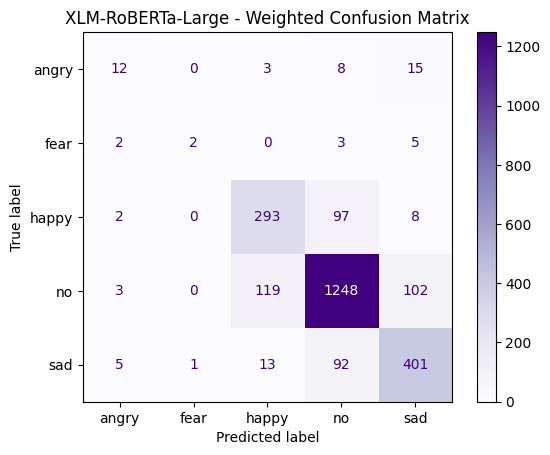


Detailed Classification Report:
              precision    recall  f1-score   support

       angry      0.500     0.316     0.387        38
        fear      0.667     0.167     0.267        12
       happy      0.685     0.733     0.708       400
          no      0.862     0.848     0.855      1472
         sad      0.755     0.783     0.769       512

    accuracy                          0.804      2434
   macro avg      0.694     0.569     0.597      2434
weighted avg      0.804     0.804     0.802      2434


✅ All results saved to xlm_weighted_results.pkl


In [2]:
# =============================
# NLP Project: XLM-RoBERTa-Large Emotion Classification (Weighted Metrics)
# =============================

!pip install -q transformers datasets scikit-learn torch

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pickle
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Dataset
# -----------------------------
train_df = pd.read_csv("/kaggle/input/nlpdataset/train.csv")[['Sentence', 'Emotion']]
val_df = pd.read_csv("/kaggle/input/nlpdataset/val.csv")[['Sentence', 'Emotion']]
test_df = pd.read_csv("/kaggle/input/nlpdataset/test.csv")[['Sentence', 'Emotion']]

# Encode labels
le = LabelEncoder()
train_df['Emotion'] = le.fit_transform(train_df['Emotion'])
val_df['Emotion'] = le.transform(val_df['Emotion'])
test_df['Emotion'] = le.transform(test_df['Emotion'])
num_labels = len(le.classes_)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# -----------------------------
# 2. Tokenization
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")

def tokenize_function(examples):
    return tokenizer(examples["Sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename label column
train_dataset = train_dataset.rename_column("Emotion", "labels")
val_dataset = val_dataset.rename_column("Emotion", "labels")
test_dataset = test_dataset.rename_column("Emotion", "labels")

# Set PyTorch format
columns = ["input_ids", "attention_mask", "labels"]
train_dataset.set_format("torch", columns=columns)
val_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)

# -----------------------------
# 3. Model
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    "xlm-roberta-large", 
    num_labels=num_labels
)

# -----------------------------
# 4. Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./xlm_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=False
)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# -----------------------------
# 5. Trainer
# -----------------------------
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# -----------------------------
# 6. Train
# -----------------------------
trainer.train()

# -----------------------------
# 7. Predict on Test Set
# -----------------------------
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=-1)
y_true = test_df["Emotion"].values
classes = le.classes_

# -----------------------------
# 8. Weighted Metrics
# -----------------------------
weighted_precision = precision_score(y_true, y_pred, average="weighted")
weighted_recall = recall_score(y_true, y_pred, average="weighted")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print("\n📊 Weighted Metrics for XLM-RoBERTa-Large")
print("-------------------------------------------")
print(f"Accuracy          : {accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall   : {weighted_recall:.4f}")
print(f"Weighted F1-score : {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Purples", values_format="d")
plt.title("XLM-RoBERTa-Large - Weighted Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=classes, digits=3)
print("\nDetailed Classification Report:")
print(report)

# -----------------------------
# 9. Save Results to Pickle
# -----------------------------
results = {
    "model_name": "xlm-roberta-large",
    "label_encoder": le,
    "preds": y_pred,
    "confusion_matrix": cm,
    "classification_report": report,
    "accuracy": accuracy,
    "weighted_precision": weighted_precision,
    "weighted_recall": weighted_recall,
    "weighted_f1": weighted_f1
}

with open("xlm_weighted_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\n✅ All results saved to xlm_weighted_results.pkl")


Computed Class Weights: tensor([12.5981, 41.4128,  1.2169,  0.3307,  0.9520])


Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

Map:   0%|          | 0/2433 [00:00<?, ? examples/s]

Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at l3cube-pune/telugu-bert and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.879400,0.830838,0.715577
2,0.818000,0.711243,0.760789
3,0.588100,0.694994,0.780929



📊 Weighted Metrics for Telugu-BERT
-------------------------------------------
Accuracy          : 0.7761
Weighted Precision: 0.8004
Weighted Recall   : 0.7761
Weighted F1-score : 0.7808


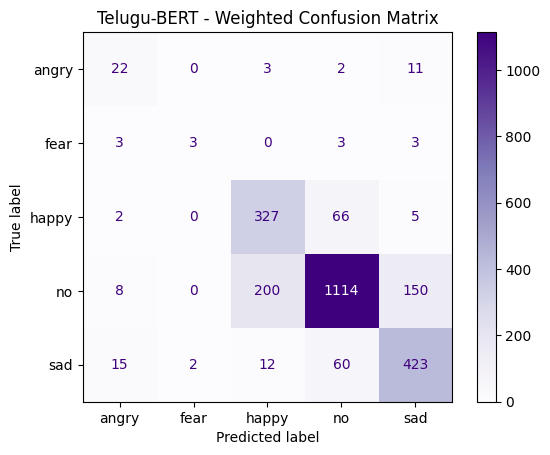


Detailed Classification Report:
              precision    recall  f1-score   support

       angry      0.440     0.579     0.500        38
        fear      0.600     0.250     0.353        12
       happy      0.603     0.818     0.694       400
          no      0.895     0.757     0.820      1472
         sad      0.715     0.826     0.766       512

    accuracy                          0.776      2434
   macro avg      0.651     0.646     0.627      2434
weighted avg      0.800     0.776     0.781      2434


✅ All results saved to telugubert_weighted_results.pkl


In [5]:
# =============================
# NLP Project: Telugu-BERT Emotion Classification (Weighted Metrics)
# =============================

!pip install -q transformers datasets scikit-learn torch

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pickle
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

# -----------------------------
# 1. Load Dataset
# -----------------------------
train_df = pd.read_csv("/kaggle/input/nlpdataset/train.csv")[['Sentence', 'Emotion']]
val_df = pd.read_csv("/kaggle/input/nlpdataset/val.csv")[['Sentence', 'Emotion']]
test_df = pd.read_csv("/kaggle/input/nlpdataset/test.csv")[['Sentence', 'Emotion']]

# Encode labels
le = LabelEncoder()
train_df['Emotion'] = le.fit_transform(train_df['Emotion'])
val_df['Emotion'] = le.transform(val_df['Emotion'])
test_df['Emotion'] = le.transform(test_df['Emotion'])
num_labels = len(le.classes_)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# -----------------------------
# 2. Compute Class Weights
# -----------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Emotion']),
    y=train_df['Emotion']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Computed Class Weights:", class_weights)

# -----------------------------
# 3. Tokenization
# -----------------------------
model_name = "l3cube-pune/telugu-bert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["Sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename label column
train_dataset = train_dataset.rename_column("Emotion", "labels")
val_dataset = val_dataset.rename_column("Emotion", "labels")
test_dataset = test_dataset.rename_column("Emotion", "labels")

# Set PyTorch format
columns = ["input_ids", "attention_mask", "labels"]
train_dataset.set_format("torch", columns=columns)
val_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)

# -----------------------------
# 4. Model
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, 
    num_labels=num_labels
)

# -----------------------------
# 5. Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./telugubert_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=False
)

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# -----------------------------
# 6. Weighted Trainer (Fixed for device)
# -----------------------------
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        device = inputs["input_ids"].device
        loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))
        outputs = model(**inputs)
        logits = outputs.logits
        loss = loss_fct(logits, labels.to(device))
        return (loss, outputs) if return_outputs else loss

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

# -----------------------------
# 7. Train
# -----------------------------
trainer.train()

# -----------------------------
# 8. Predict on Test Set
# -----------------------------
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=-1)
y_true = test_df["Emotion"].values
classes = le.classes_

# -----------------------------
# 9. Weighted Metrics
# -----------------------------
weighted_precision = precision_score(y_true, y_pred, average="weighted")
weighted_recall = recall_score(y_true, y_pred, average="weighted")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print("\n📊 Weighted Metrics for Telugu-BERT")
print("-------------------------------------------")
print(f"Accuracy          : {accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall   : {weighted_recall:.4f}")
print(f"Weighted F1-score : {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Purples", values_format="d")
plt.title("Telugu-BERT - Weighted Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=classes, digits=3)
print("\nDetailed Classification Report:")
print(report)

# -----------------------------
# 10. Save Results to Pickle
# -----------------------------
results = {
    "model_name": "telugu-bert",
    "label_encoder": le,
    "preds": y_pred,
    "confusion_matrix": cm,
    "classification_report": report,
    "accuracy": accuracy,
    "weighted_precision": weighted_precision,
    "weighted_recall": weighted_recall,
    "weighted_f1": weighted_f1
}

with open("telugubert_weighted_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\n✅ All results saved to telugubert_weighted_results.pkl")


Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

Map:   0%|          | 0/2433 [00:00<?, ? examples/s]

Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.972700,0.895136,0.697493
2,0.902000,0.809554,0.738183
3,0.785100,0.834447,0.723798



📊 Weighted Metrics for mBERT
-------------------------------------------
Accuracy          : 0.7054
Weighted Precision: 0.7394
Weighted Recall   : 0.7054
Weighted F1-score : 0.7134


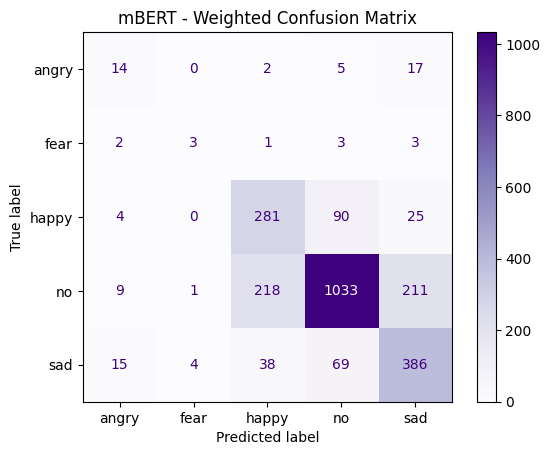


Detailed Classification Report:
              precision    recall  f1-score   support

       angry      0.318     0.368     0.341        38
        fear      0.375     0.250     0.300        12
       happy      0.520     0.703     0.598       400
          no      0.861     0.702     0.773      1472
         sad      0.601     0.754     0.669       512

    accuracy                          0.705      2434
   macro avg      0.535     0.555     0.536      2434
weighted avg      0.739     0.705     0.713      2434


✅ All results saved to mbet_weighted_results.pkl


In [12]:
!pip install -q transformers datasets scikit-learn torch

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pickle
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Dataset
# -----------------------------
train_df = pd.read_csv("/kaggle/input/nlpdataset/train.csv")[['Sentence', 'Emotion']]
val_df = pd.read_csv("/kaggle/input/nlpdataset/val.csv")[['Sentence', 'Emotion']]
test_df = pd.read_csv("/kaggle/input/nlpdataset/test.csv")[['Sentence', 'Emotion']]

# Encode labels
le = LabelEncoder()
train_df['Emotion'] = le.fit_transform(train_df['Emotion'])
val_df['Emotion'] = le.transform(val_df['Emotion'])
test_df['Emotion'] = le.transform(test_df['Emotion'])
num_labels = len(le.classes_)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Emotion']),
    y=train_df['Emotion']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# -----------------------------
# 2. Tokenization
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

def tokenize_function(examples):
    return tokenizer(examples["Sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename label column
train_dataset = train_dataset.rename_column("Emotion", "labels")
val_dataset = val_dataset.rename_column("Emotion", "labels")
test_dataset = test_dataset.rename_column("Emotion", "labels")

# Set PyTorch format
columns = ["input_ids", "attention_mask", "labels"]
train_dataset.set_format("torch", columns=columns)
val_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)

# -----------------------------
# 3. Model
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels
)

# -----------------------------
# 4. Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./mbet_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=False
)

# -----------------------------
# 5. Weighted Trainer
# -----------------------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Send class_weights to same device as labels to avoid DataParallel errors
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(labels.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

# -----------------------------
# 6. Train
# -----------------------------
trainer.train()

# -----------------------------
# 7. Predict on Test Set
# -----------------------------
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=-1)
y_true = test_df["Emotion"].values
classes = le.classes_

# -----------------------------
# 8. Weighted Metrics
# -----------------------------
weighted_precision = precision_score(y_true, y_pred, average="weighted")
weighted_recall = recall_score(y_true, y_pred, average="weighted")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print("\n📊 Weighted Metrics for mBERT")
print("-------------------------------------------")
print(f"Accuracy          : {accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall   : {weighted_recall:.4f}")
print(f"Weighted F1-score : {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Purples", values_format="d")
plt.title("mBERT - Weighted Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=classes, digits=3)
print("\nDetailed Classification Report:")
print(report)

# -----------------------------
# 9. Save Results to Pickle
# -----------------------------
results = {
    "model_name": "bert-base-multilingual-cased",
    "label_encoder": le,
    "preds": y_pred,
    "confusion_matrix": cm,
    "classification_report": report,
    "accuracy": accuracy,
    "weighted_precision": weighted_precision,
    "weighted_recall": weighted_recall,
    "weighted_f1": weighted_f1
}

with open("mbet_weighted_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\n✅ All results saved to mbet_weighted_results.pkl")


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Map:   0%|          | 0/19464 [00:00<?, ? examples/s]

Map:   0%|          | 0/2433 [00:00<?, ? examples/s]

Map:   0%|          | 0/2434 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,1.088700,1.109059,0.688450
2,0.990300,0.930579,0.713522
3,0.819900,0.910471,0.678175



📊 Weighted Metrics for DistilBERT
-------------------------------------------
Accuracy          : 0.6763
Weighted Precision: 0.7126
Weighted Recall   : 0.6763
Weighted F1-score : 0.6854


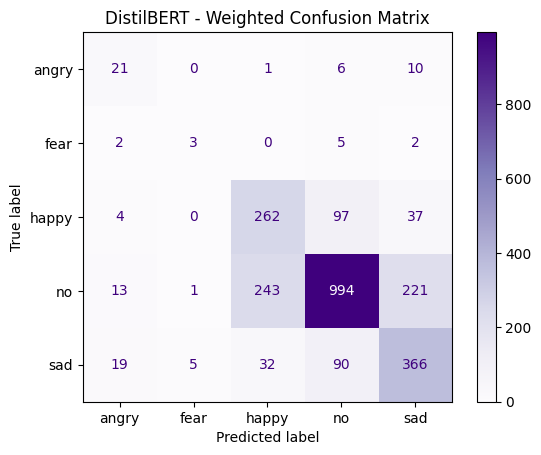


Detailed Classification Report:
              precision    recall  f1-score   support

       angry      0.356     0.553     0.433        38
        fear      0.333     0.250     0.286        12
       happy      0.487     0.655     0.559       400
          no      0.834     0.675     0.746      1472
         sad      0.575     0.715     0.638       512

    accuracy                          0.676      2434
   macro avg      0.517     0.570     0.532      2434
weighted avg      0.713     0.676     0.685      2434


✅ All results saved to distilbert_weighted_results.pkl


In [13]:
!pip install -q transformers datasets scikit-learn torch

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    ConfusionMatrixDisplay
)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pickle
import matplotlib.pyplot as plt

# -----------------------------
# 1. Load Dataset
# -----------------------------
train_df = pd.read_csv("/kaggle/input/nlpdataset/train.csv")[['Sentence', 'Emotion']]
val_df = pd.read_csv("/kaggle/input/nlpdataset/val.csv")[['Sentence', 'Emotion']]
test_df = pd.read_csv("/kaggle/input/nlpdataset/test.csv")[['Sentence', 'Emotion']]

# Encode labels
le = LabelEncoder()
train_df['Emotion'] = le.fit_transform(train_df['Emotion'])
val_df['Emotion'] = le.transform(val_df['Emotion'])
test_df['Emotion'] = le.transform(test_df['Emotion'])
num_labels = len(le.classes_)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Emotion']),
    y=train_df['Emotion']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Convert to HuggingFace Dataset
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# -----------------------------
# 2. Tokenization
# -----------------------------
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")

def tokenize_function(examples):
    return tokenizer(examples["Sentence"], padding="max_length", truncation=True, max_length=128)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Rename label column
train_dataset = train_dataset.rename_column("Emotion", "labels")
val_dataset = val_dataset.rename_column("Emotion", "labels")
test_dataset = test_dataset.rename_column("Emotion", "labels")

# Set PyTorch format
columns = ["input_ids", "attention_mask", "labels"]
train_dataset.set_format("torch", columns=columns)
val_dataset.set_format("torch", columns=columns)
test_dataset.set_format("torch", columns=columns)

# -----------------------------
# 3. Model
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-multilingual-cased",
    num_labels=num_labels
)

# -----------------------------
# 4. Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./distilbert_results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    load_best_model_at_end=False
)

# -----------------------------
# 5. Weighted Trainer
# -----------------------------
class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # Send class_weights to same device as labels
        loss_fct = torch.nn.CrossEntropyLoss(weight=self.class_weights.to(labels.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# Metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

# -----------------------------
# 6. Train
# -----------------------------
trainer.train()

# -----------------------------
# 7. Predict on Test Set
# -----------------------------
preds_output = trainer.predict(test_dataset)
y_pred = np.argmax(preds_output.predictions, axis=-1)
y_true = test_df["Emotion"].values
classes = le.classes_

# -----------------------------
# 8. Weighted Metrics
# -----------------------------
weighted_precision = precision_score(y_true, y_pred, average="weighted")
weighted_recall = recall_score(y_true, y_pred, average="weighted")
weighted_f1 = f1_score(y_true, y_pred, average="weighted")
accuracy = accuracy_score(y_true, y_pred)

print("\n📊 Weighted Metrics for DistilBERT")
print("-------------------------------------------")
print(f"Accuracy          : {accuracy:.4f}")
print(f"Weighted Precision: {weighted_precision:.4f}")
print(f"Weighted Recall   : {weighted_recall:.4f}")
print(f"Weighted F1-score : {weighted_f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap="Purples", values_format="d")
plt.title("DistilBERT - Weighted Confusion Matrix")
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=classes, digits=3)
print("\nDetailed Classification Report:")
print(report)

# -----------------------------
# 9. Save Results to Pickle
# -----------------------------
results = {
    "model_name": "distilbert-base-multilingual-cased",
    "label_encoder": le,
    "preds": y_pred,
    "confusion_matrix": cm,
    "classification_report": report,
    "accuracy": accuracy,
    "weighted_precision": weighted_precision,
    "weighted_recall": weighted_recall,
    "weighted_f1": weighted_f1
}

with open("distilbert_weighted_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\n✅ All results saved to distilbert_weighted_results.pkl")


In [ ]:
# =============================
# NLP Project: Emotion Classification (Weighted - XLM-RoBERTa)
# Kaggle-ready, GPU-safe
# =============================

!pip install -q transformers datasets scikit-learn torch

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)
from datasets import Dataset
import pickle
from torch.nn import CrossEntropyLoss

# -----------------------------
# 1. Load Dataset
# -----------------------------
train_df = pd.read_csv("/kaggle/input/nlpdataset/train.csv")[['Sentence', 'Emotion']]
val_df = pd.read_csv("/kaggle/input/nlpdataset/val.csv")[['Sentence', 'Emotion']]
test_df = pd.read_csv("/kaggle/input/nlpdataset/test.csv")[['Sentence', 'Emotion']]

# -----------------------------
# 2. Label Encoding
# -----------------------------
le = LabelEncoder()
train_df['Emotion'] = le.fit_transform(train_df['Emotion'])
val_df['Emotion'] = le.transform(val_df['Emotion'])
test_df['Emotion'] = le.transform(test_df['Emotion'])
num_labels = len(le.classes_)

# -----------------------------
# 3. Compute Class Weights
# -----------------------------
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Emotion']),
    y=train_df['Emotion']
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("✅ Class Weights:", class_weights)

# -----------------------------
# 4. Convert to HuggingFace Dataset
# -----------------------------
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# -----------------------------
# 5. Tokenizer and Tokenization
# -----------------------------
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(examples):
    return tokenizer(examples["Sentence"], padding="max_length", truncation=True, max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_val = val_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_train = tokenized_train.rename_column("Emotion", "labels")
tokenized_val = tokenized_val.rename_column("Emotion", "labels")
tokenized_test = tokenized_test.rename_column("Emotion", "labels")

tokenized_train.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_val.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# -----------------------------
# 6. Weighted Trainer Class (final stable version)
# -----------------------------
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        # Handle multi-GPU DataParallel safely
        real_model = model.module if hasattr(model, "module") else model
        device = next(real_model.parameters()).device

        loss_fct = CrossEntropyLoss(weight=class_weights.to(device))
        loss = loss_fct(logits.view(-1, real_model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# -----------------------------
# 7. Model Initialization
# -----------------------------
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# -----------------------------
# 8. Training Arguments
# -----------------------------
training_args = TrainingArguments(
    output_dir="./results_xlm_roberta_weighted",
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    fp16=True  # mixed precision for GPU
)

# -----------------------------
# 9. Metrics Function
# -----------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

# -----------------------------
# 10. Trainer Setup and Train
# -----------------------------
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics,
)

trainer.train()

# -----------------------------
# 11. Evaluate on Test Set
# -----------------------------
preds_output = trainer.predict(tokenized_test)
preds = np.argmax(preds_output.predictions, axis=-1)

cm = confusion_matrix(test_df['Emotion'], preds)
report = classification_report(test_df['Emotion'], preds, target_names=le.classes_, output_dict=True)
acc = accuracy_score(test_df['Emotion'], preds)

print(f"\n✅ XLM-RoBERTa Weighted Accuracy: {acc:.4f}")
print(f"Confusion Matrix:\n{cm}")
print(classification_report(test_df['Emotion'], preds, target_names=le.classes_))

# -----------------------------
# 12. Save Results
# -----------------------------
results = {
    "label_encoder": le,
    "predictions": preds,
    "confusion_matrix": cm,
    "classification_report": report,
    "accuracy": acc
}

with open("xlm_roberta_weighted_results.pkl", "wb") as f:
    pickle.dump(results, f)

print("\n✅ Training complete! Results saved to xlm_roberta_weighted_results.pkl")
